## Demo Air Passenger

In [18]:
# Import the Required libraries
import pandas as pd 
import numpy as np
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 15,6

import warnings 
warnings.filterwarnings('ignore')

In [19]:
data = pd.read_csv('AirPassengers.csv')

In [20]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [21]:
data['Month']= data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]),15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [22]:
ts = data['#Passengers']

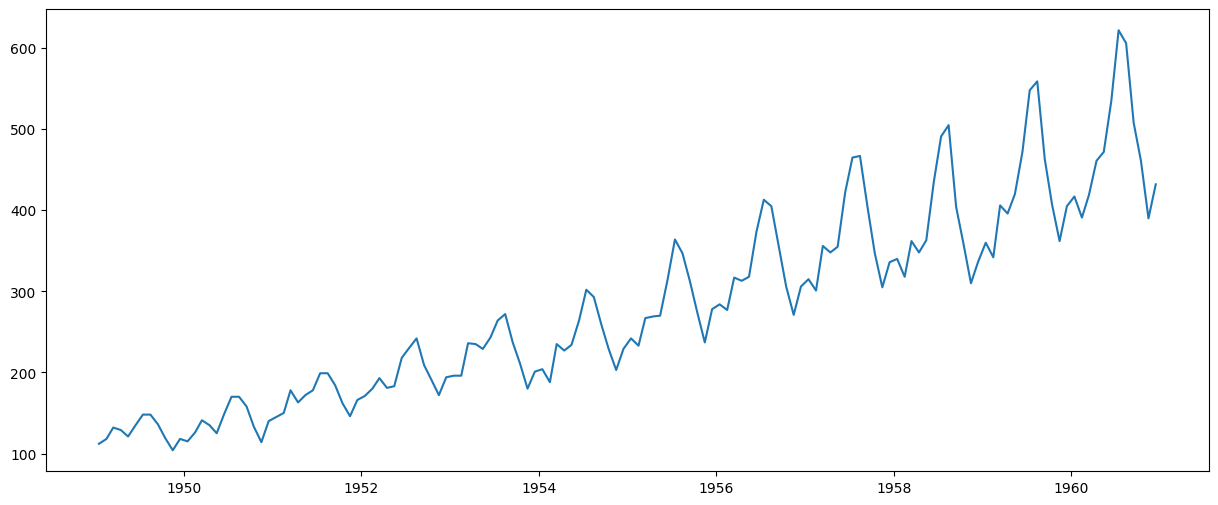

In [23]:
plt.plot(ts)

In [24]:
ts_log = np.log(ts)

In [25]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center= False).mean()
    rolstd = timeseries.rolling(window=52, center= False).std()

    orig = plt.plot(timeseries, color='blue', label='original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard deviation')
    plt.show(block=False)


    print('Result of Dicky-Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput= pd.Series(dftest[0:4], index=['Test Statistic', 'p-value','#Lags Used','Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

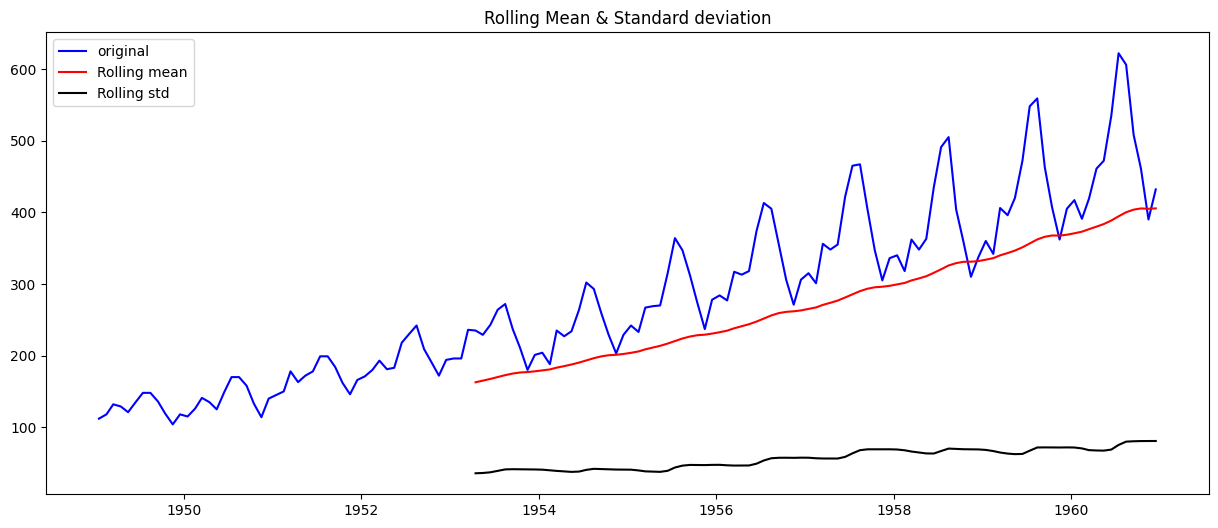

Result of Dicky-Fuller Test
Test Statistic                  0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


In [26]:
test_stationarity(data['#Passengers'])

### Decomposition 

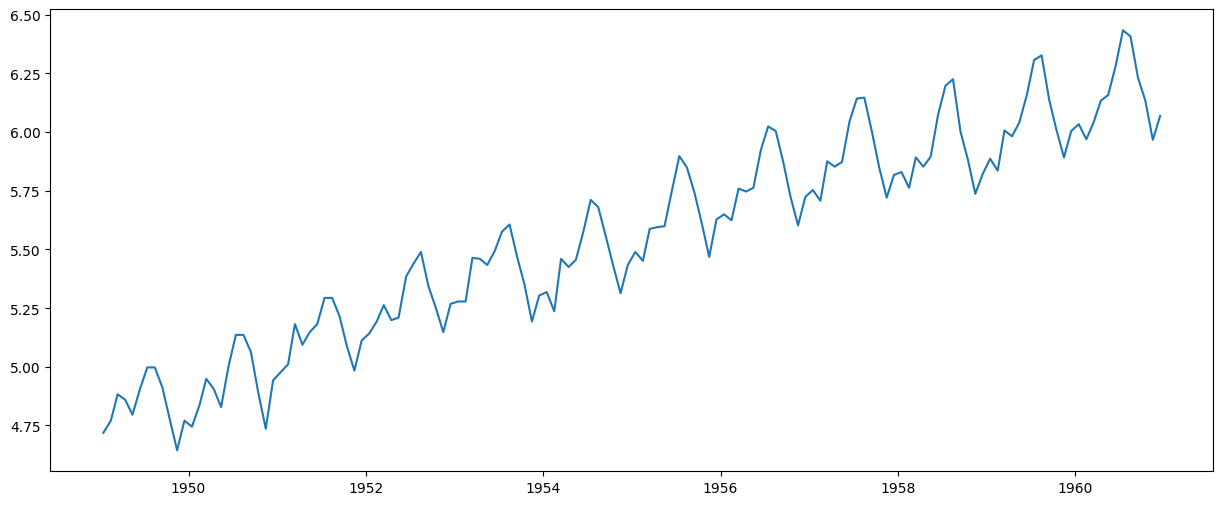

In [27]:
# plot the moving average
plt.plot(ts_log)

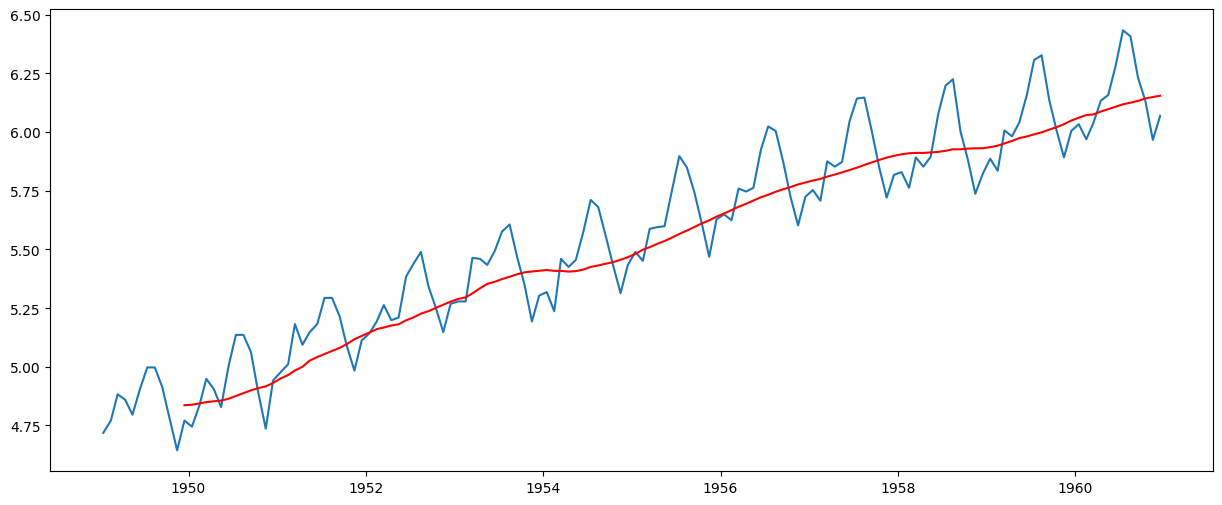

In [28]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color ='red')

### Differencing 

In [29]:
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

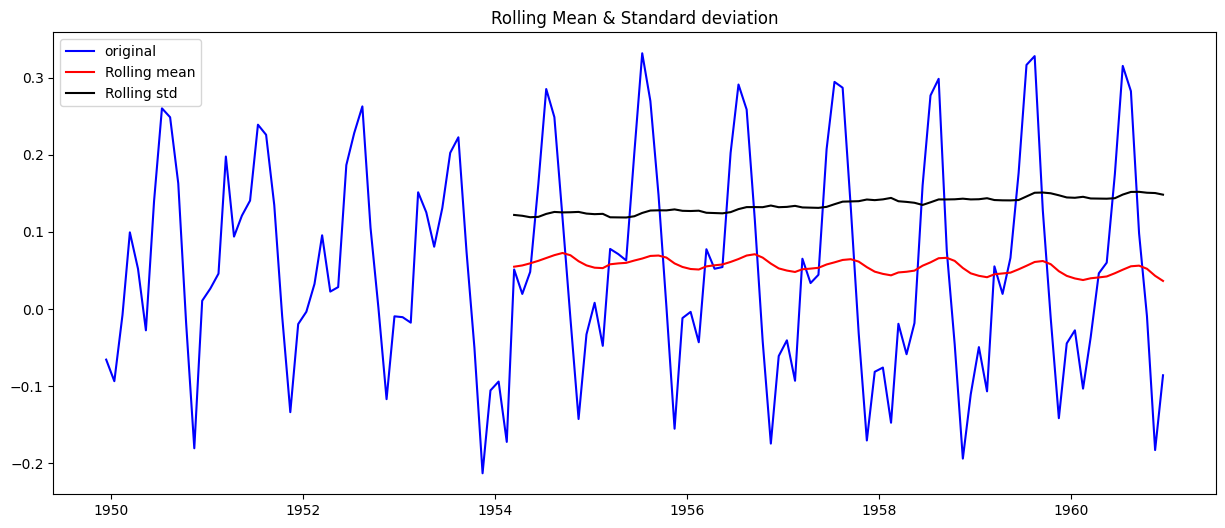

Result of Dicky-Fuller Test
Test Statistic                 -3.162908
p-value                         0.022235
#Lags Used                     13.000000
Number of Observation Used    119.000000
Critical Value (1%)            -3.486535
Critical Value (5%)            -2.886151
Critical Value (10%)           -2.579896
dtype: float64


In [30]:
test_stationarity(ts_log_mv_diff)

#### --As we see in the critical value of test statistics is less than 1% which show 99% confidence

## Time series Forecasting

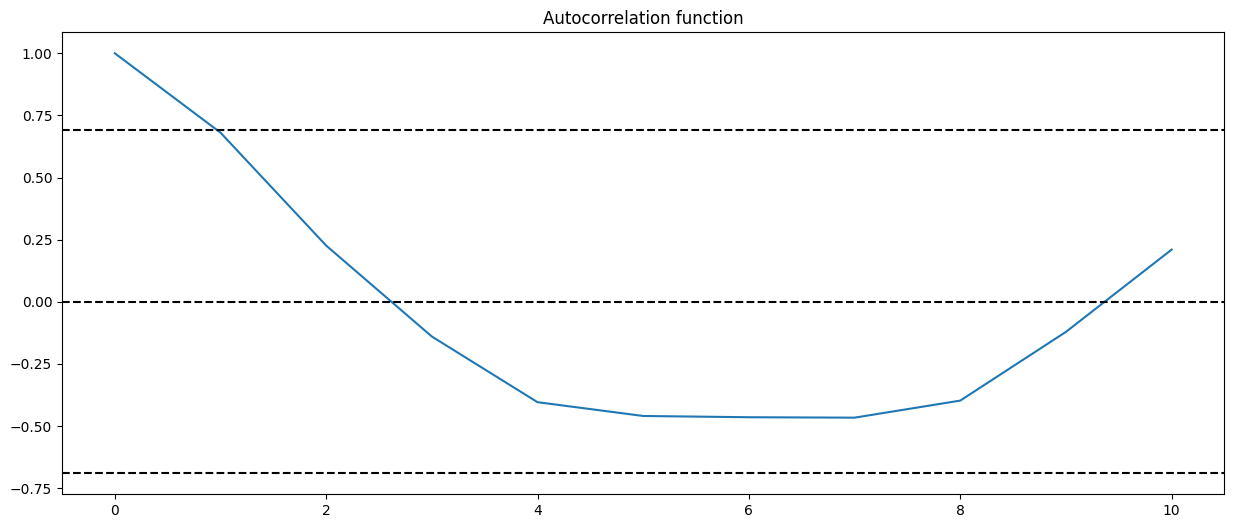

In [31]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='black')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color = 'black')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color = 'black')
plt.title('Autocorrelation function')
plt.show()

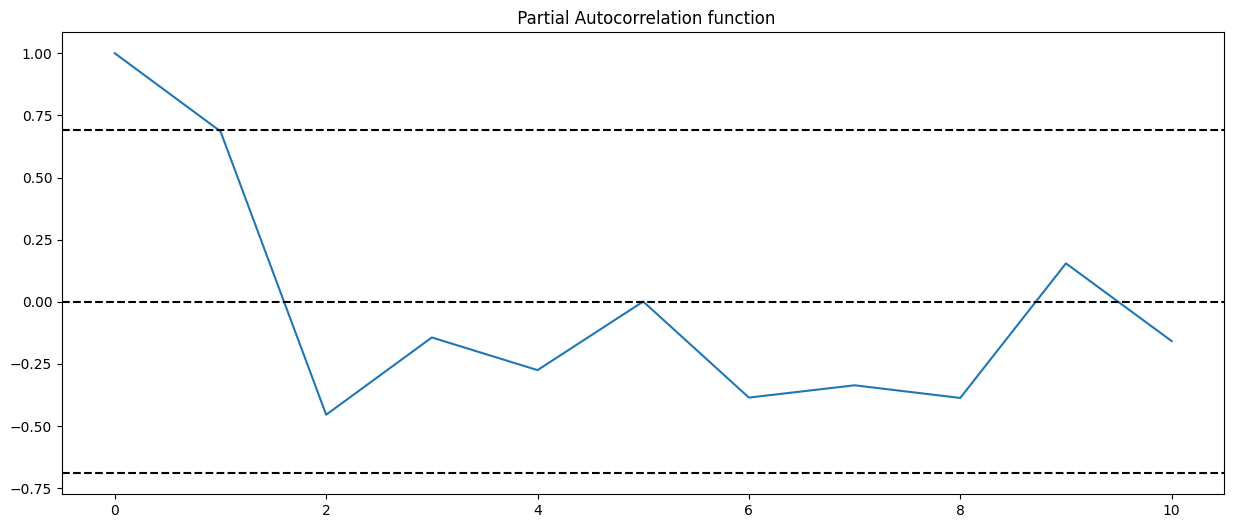

In [32]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='black')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color = 'black')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color = 'black')
plt.title(' Partial Autocorrelation function')
plt.show()

In [33]:
# model = ARIMA(ts_log, order=(1,1,0))
# results_ARIMA = model.fit(disp=-1)
# plt.plot(ts_log_mv_diff)
# plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %4f'%sum((results_ARIMA.fittedvalues[1:]- ts_log_mv_diff)**2))

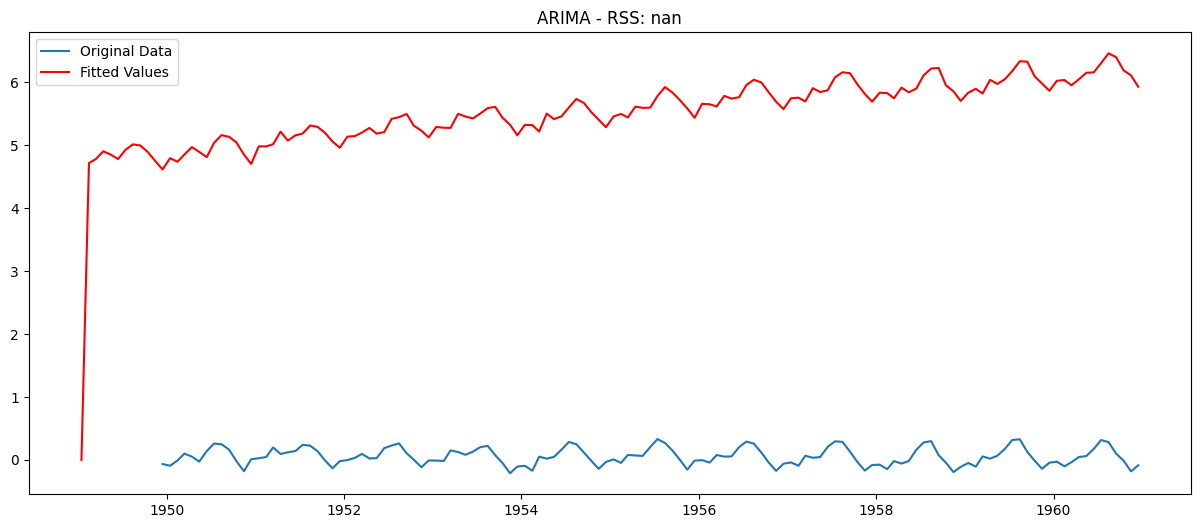

In [34]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Create an ARIMA model with order (1, 1, 0)
model = ARIMA(ts_log, order=(1, 1, 0))

# Fit the ARIMA model
results_ARIMA = model.fit()

# Get the fitted values
fitted_values = results_ARIMA.fittedvalues

# Calculate the residual sum of squares (RSS)
rss = sum((fitted_values - ts_log_mv_diff) ** 2)

# Plot the original data and fitted values
plt.plot(ts_log_mv_diff, label='Original Data')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('ARIMA - RSS: %.4f' % rss)
plt.legend()
plt.show()


In [35]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-01-15    0.000000
1949-02-15    4.718499
1949-03-15    4.781405
1949-04-15    4.905833
1949-05-15    4.855090
dtype: float64